In [1]:
!pip install easyocr
!pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 68.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.3/281.3 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.1/875.1 kB 39.5 MB/s eta 0:00:00


In [2]:
pip install pytesseract

In [3]:
import cv2
import numpy as np
from google.colab import files
import torch
from PIL import Image
import easyocr
from transformers import YolosImageProcessor, YolosForObjectDetection
import io
import os
import pytesseract


In [4]:
def load_image(file_or_path):
    if isinstance(file_or_path, str):
        # If it's a file path
        return cv2.imread(file_or_path)
    elif isinstance(file_or_path, bytes):
        # If it's bytes (e.g., from uploaded file)
        nparr = np.frombuffer(file_or_path, np.uint8)
        return cv2.imdecode(nparr, cv2.IMREAD_COLOR)
    else:
        raise ValueError("Unsupported file type. Please provide a file path or bytes.")

In [5]:
from ultralytics import YOLO

def load_image(file_or_path):
    if isinstance(file_or_path, str):
        # If it's a file path
        return cv2.imread(file_or_path)
    elif isinstance(file_or_path, bytes):
        # If it's bytes (e.g., from uploaded file)
        nparr = np.frombuffer(file_or_path, np.uint8)
        return cv2.imdecode(nparr, cv2.IMREAD_COLOR)
    else:
        raise ValueError("Unsupported file type. Please provide a file path or bytes.")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [6]:
def preprocess_image(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    denoised = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply adaptive thresholding
    thresh = cv2.adaptiveThreshold(denoised, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

    return thresh

In [8]:
def extract_text(image):
    # Use EasyOCR to extract text
    reader = easyocr.Reader(['en'])  # Initialize for English
    result = reader.readtext(image)
    return result

def parse_aadhaar_info(ocr_result):
    aadhaar_info = {
        'name': '',
        'year_of_birth': '',
        'gender': '',
        'aadhaar_number': ''
    }

    for detection in ocr_result:
        text = detection[1].lower()
        if 'year of birth' in text:
            aadhaar_info['year_of_birth'] = text.split(':')[-1].strip()
        elif 'male' in text or 'female' in text:
            aadhaar_info['gender'] = text.strip()
        elif len(text) == 14 and text.replace(' ', '').isdigit():
            aadhaar_info['aadhaar_number'] = text
        elif not aadhaar_info['name'] and text.replace(' ', '').isalpha():
            aadhaar_info['name'] = text.title()

    return aadhaar_info

def process_document(file_or_path, model):
    try:
        # Load the image
        image = load_image(file_or_path)

        # Save the image for debugging
        cv2.imwrite('debug_input.jpg', image)

        # Perform YOLO detection
        results = model(image)

        # Get the bounding box with the highest confidence
        if len(results[0].boxes) > 0:
            box = results[0].boxes[0].xyxy[0].cpu().numpy()  # Get the first bounding box
            id_card = image[int(box[1]):int(box[3]), int(box[0]):int(box[2])]
        else:
            print("No ID card detected. Processing the entire image.")
            id_card = image

        # Save the cropped image for debugging
        cv2.imwrite('debug_cropped.jpg', id_card)

        # Preprocess the image
        preprocessed = preprocess_image(id_card)

        # Save the preprocessed image for debugging
        cv2.imwrite('debug_preprocessed.jpg', preprocessed)

        # Extract text
        ocr_result = extract_text(preprocessed)

        # Parse Aadhaar card information
        aadhaar_info = parse_aadhaar_info(ocr_result)

        return aadhaar_info
    except Exception as e:
        print(f"An error occurred while processing the document: {str(e)}")
        return None


PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



Saving WhatsApp Image 2024-09-28 at 13.42.52.jpeg to WhatsApp Image 2024-09-28 at 13.42.52 (2).jpeg
Processing WhatsApp Image 2024-09-28 at 13.42.52 (2).jpeg...

0: 480x640 3 persons, 506.5ms
Speed: 18.4ms preprocess, 506.5ms inference, 25.9ms postprocess per image at shape (1, 3, 480, 640)


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% CompleteExtracted ID Card Information:
Name: 
Year_of_birth: 
Gender: 
Aadhaar_number: 


Debug Images:


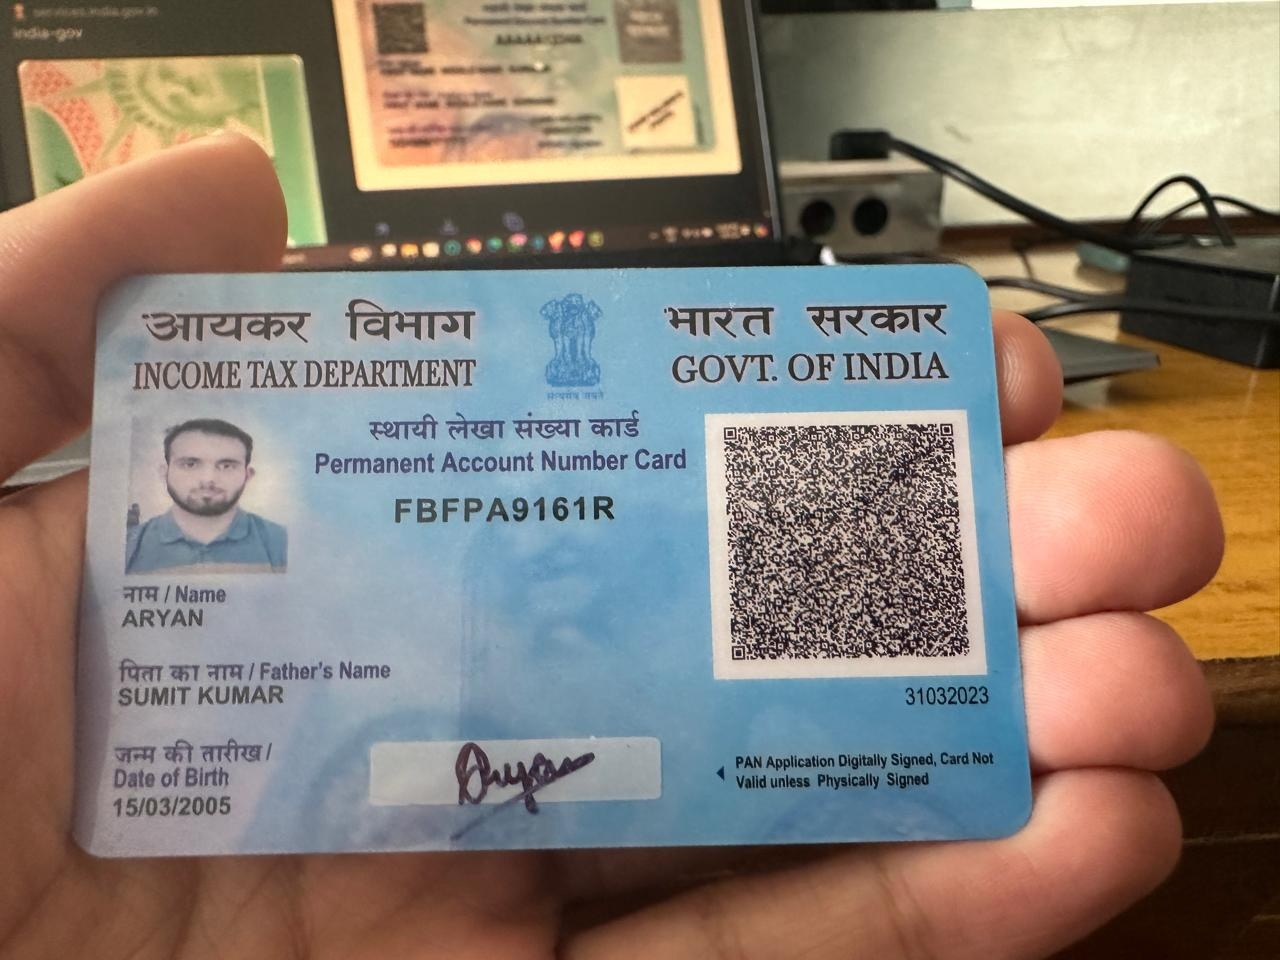

debug_input.jpg (exists)


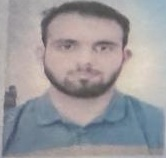

debug_cropped.jpg (exists)


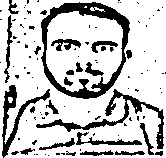

debug_preprocessed.jpg (exists)


In [9]:
model = YOLO('yolov5s.pt')

# Main execution
uploaded = files.upload()

for filename, file_content in uploaded.items():
    print(f"Processing {filename}...")
    id_info = process_document(file_content, model)
    if id_info:
        print("Extracted ID Card Information:")
        for key, value in id_info.items():
            print(f"{key.capitalize()}: {value}")
    else:
        print("Failed to extract information from the document.")
    print("\n" + "="*50 + "\n")

# Display debug images
from IPython.display import Image as IPImage, display

print("Debug Images:")
for img_name in ['debug_input.jpg', 'debug_cropped.jpg', 'debug_preprocessed.jpg']:
    if os.path.exists(img_name):
        display(IPImage(filename=img_name))
        print(f"{img_name} (exists)")
    else:
        print(f"{img_name} (does not exist)")

In [10]:
pip install deepface

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 62.9 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.6.0-py2.py3-none-any.whl size=117030 sha256=58809ea74a7cacc65cdbe010b4003a11a69d2f66f09096a8057ce9d5e1e51e40
  Stored in directory: /root/.cache/pip/wheels/d6/6d/5d/5b73fa0f46d01a793713f8859201361e9e581ced8c75e5c6a3
Successfully built fire


Error with model VGG-Face: The layer sequential_20 has never been called and thus has no defined input.. Skipping...
Error with model DeepFace: DeepFace model requires LocallyConnected2D but it is no longer supported after tf 2.12 but you have 2.17. You need to downgrade your tf.. Skipping...
Match: True
Similarity: 0.4102
Model distances: [0.6250039647776141, 0.19533637862650677]


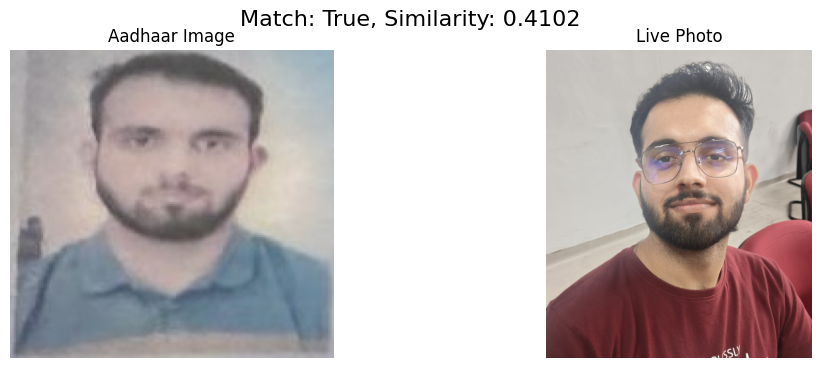

In [30]:
import cv2
import numpy as np
from deepface import DeepFace
import matplotlib.pyplot as plt

# Optional preprocessing function, but not applied to DeepFace input
def preprocess_image(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Histogram equalization
    equalized = cv2.equalizeHist(gray)

    # Adaptive histogram equalization
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    adaptive_eq = clahe.apply(equalized)

    # Denoise
    denoised = cv2.fastNlMeansDenoising(adaptive_eq, None, 10, 7, 21)

    return denoised

def verify_identity(img1_path, img2_path, threshold=0.6):
    # Verify using DeepFace
    models = ["VGG-Face", "Facenet", "OpenFace", "DeepFace"]
    results = []

    for model in models:
        try:
            result = DeepFace.verify(img1_path=img1_path,
                                     img2_path=img2_path,
                                     model_name=model,
                                     distance_metric="cosine",
                                     enforce_detection=False)  # Skipping detection if already detected faces
            results.append(result["distance"])
        except Exception as e:
            print(f"Error with model {model}: {e}. Skipping...")

    # Calculate average distance
    avg_distance = np.mean(results)
    similarity = avg_distance

    is_match = avg_distance <= threshold  # Adjusted threshold for more realistic matching

    return is_match, similarity, results

# Paths to images (replace these paths with the actual images)
aadhaar_image_path = "/content/debug_cropped.jpg"
live_photo_path = "/content/WhatsApp Image 2024-09-29 at 07.07.10.jpeg"

# Verify identity
is_match, similarity, model_distances = verify_identity(aadhaar_image_path, live_photo_path)

# Display results
print(f"Match: {is_match}")
print(f"Similarity: {similarity:.4f}")
print("Model distances:", model_distances)

# Visualize results
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.imshow(cv2.imread(aadhaar_image_path)[:,:,::-1])
plt.title("Aadhaar Image")
plt.axis('off')
plt.subplot(122)
plt.imshow(cv2.imread(live_photo_path)[:,:,::-1])
plt.title("Live Photo")
plt.axis('off')
plt.suptitle(f"Match: {is_match}, Similarity: {similarity:.4f}", fontsize=16)
plt.show()


Saving WhatsApp Image 2024-06-09 at 16.08.55.jpeg to WhatsApp Image 2024-06-09 at 16.08.55 (2).jpeg
Processing WhatsApp Image 2024-06-09 at 16.08.55 (2).jpeg...


An error occurred while processing the document: local variable 'img' referenced before assignment
Failed to extract information from the document.




/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.13k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/26.0M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

Saving WhatsApp Image 2024-06-09 at 16.08.55.jpeg to WhatsApp Image 2024-06-09 at 16.08.55 (1).jpeg


In [ ]:
!pip install transformers
from transformers import AutoImageProcessor, AutoModelForTokenClassification # Import AutoImageProcessor

# Load model and processor directly
processor = AutoImageProcessor.from_pretrained("arunreddy/pan-kyc")
model = AutoModelForTokenClassification.from_pretrained("arunreddy/pan-kyc")

OSError: arunreddy/pan-kyc does not appear to have a file named preprocessor_config.json. Checkout 'https://huggingface.co/arunreddy/pan-kyc/tree/main' for available files.

In [ ]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("token-classification", model="arunreddy/pan-kyc")

pytorch_model.bin:   0%|          | 0.00/504M [00:00<?, ?B/s]

OSError: Can't load tokenizer for 'arunreddy/pan-kyc'. If you were trying to load it from 'https://huggingface.co/models', make sure you don't have a local directory with the same name. Otherwise, make sure 'arunreddy/pan-kyc' is the correct path to a directory containing all relevant files for a LayoutLMv3TokenizerFast tokenizer.

In [ ]:
!pip install transformers torch


In [ ]:
!pip install LayoutLMv3Tokenizer

ERROR: Could not find a version that satisfies the requirement LayoutLMv3Tokenizer (from versions: none)
ERROR: No matching distribution found for LayoutLMv3Tokenizer


In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, LayoutLMv3Tokenizer # Import LayoutLMv3Tokenizer
import torch

# Load the model and tokenizer
model_name = "arunreddy/pan-kyc"
# Load LayoutLMv3 tokenizer from the official Hugging Face model as a fallback
tokenizer = LayoutLMv3Tokenizer.from_pretrained("microsoft/layoutlmv3-base", use_fast=True)
model = AutoModelForTokenClassification.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
words = ["Sample", "text", "for", "token", "classification"]

# Dummy bounding boxes (top-left and bottom-right coordinates)
# These should be replaced with actual bounding box coordinates from OCR.
# Format: [x0, y0, x1, y1] for each word
boxes = [
    [0, 0, 50, 50],   # Box for "Sample"
    [60, 0, 100, 50], # Box for "text"
    [110, 0, 150, 50],# Box for "for"
    [160, 0, 210, 50],# Box for "token"
    [220, 0, 300, 50] # Box for "classification"
]

# Tokenize the input words with bounding boxes
inputs = tokenizer(words, boxes=boxes, return_tensors="pt", is_split_into_words=True)

# Run inference
outputs = model(**inputs)

# Extract logits and predictions
logits = outputs.logits
predictions = torch.argmax(logits, dim=2)

# Decode predictions
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
predicted_labels = [model.config.id2label[p.item()] for p in predictions[0]]

# Print tokens with predicted labels
for token, label in zip(tokens, predicted_labels):
    print(f"{token}: {label}")

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


<s>: O
ĠSample: O
Ġtext: O
Ġfor: O
Ġtoken: O
Ġclassification: O
</s>: O


ValueError: Words must be of type `List[str]` (single pretokenized example), or `List[List[str]]` (batch of pretokenized examples).